In [1]:
import numpy as np
from scipy import misc, optimize, fft as scipy_fft
import embree
import trimesh
from matplotlib import pyplot, colors, cm
from PIL import Image
from IPython.display import display

def sampling_lattice(res, pitch=1.0):
    """Return an array of shape (res,) containing the coordinates of a sampling lattice with 0 as one of the samples."""
    return scipy_fft.fftshift(scipy_fft.fftfreq(res).astype(np.float32) * (res * pitch))

def display_image(values, color_map=None, absolute=True, normalize=True, flip=False):
    """Display an array as an image using a color map. The image can be normalized, shifted and/or flipped."""
    values = np.abs(values) if absolute else values
    values = values * np.nan_to_num(1.0 / np.amax(values)) if normalize else values
    values = np.flip(values) if flip else values
    color_values = cm.get_cmap(color_map)(values, bytes=True)
    display(Image.fromarray(color_values).transpose(Image.ROTATE_90))

z_r = -17.0
z_a = 10.0
z_b = 30.0

size_r = 5.5
size_p = 5.0
size_a = size_r * z_a / abs(z_r) + size_p
size_b = size_r * z_b / abs(z_r) + size_p

n_r = 512
n_a = 45
n_b = 45

w_r = size_r / n_r
w_p = size_p
w_a = size_a / n_a
w_b = size_b / n_b

z_f = 100.0

In [2]:
class Scene3D:
    def __init__(self, filename):
        self.trimesh = trimesh.load_mesh(filename)
        if isinstance(self.trimesh, trimesh.Scene):
            self.meshes = list(self.trimesh.geometry.values())
        if isinstance(self.trimesh, trimesh.Trimesh):
            self.meshes = [self.trimesh]

        self.device = embree.Device()
        self.scene = self.device.make_scene()
        for mesh in self.meshes:
            geometry = self.device.make_geometry(embree.GeometryType.Triangle)
            vertex_buffer = geometry.set_new_buffer(embree.BufferType.Vertex, 0, embree.Format.Float3, 3 * np.dtype('float32').itemsize, mesh.vertices.shape[0])
            index_buffer = geometry.set_new_buffer(embree.BufferType.Index, 0, embree.Format.Uint3, 3 * np.dtype('uint32').itemsize, mesh.faces.shape[0])
            vertex_buffer[:] = mesh.vertices
            index_buffer[:] = mesh.faces
            geometry.commit()
            self.scene.attach_geometry(geometry)
            geometry.release()
        self.scene.commit()

    def rayCast(self, ray_origins, ray_directions):
        rayhit = embree.RayHit1M(ray_origins.shape[0])
        rayhit.org[:] = ray_origins
        rayhit.dir[:] = ray_directions
        rayhit.tnear[:] = 0
        rayhit.tfar[:] = np.inf
        rayhit.flags[:] = 0
        rayhit.prim_id[:] = embree.INVALID_GEOMETRY_ID
        rayhit.geom_id[:] = embree.INVALID_GEOMETRY_ID

        context = embree.IntersectContext()
        self.scene.intersect1M(context, rayhit)

        ray_colors = np.zeros((ray_origins.shape[0], 4), dtype=np.uint8)
        for mesh_id in range(len(self.meshes)):
            mask = rayhit.geom_id == mesh_id
            hit_uv = rayhit.uv[mask, np.newaxis, :]
            texture_uv = self.meshes[mesh_id].visual.uv[self.meshes[mesh_id].faces[rayhit.prim_id[mask], :], :]
            interpolated_uv = (1.0 - hit_uv[..., 0] - hit_uv[..., 1]) * texture_uv[:, 0, :] + hit_uv[..., 0] * texture_uv[:, 1, :] + hit_uv[..., 1] * texture_uv[:, 2, :]
            ray_colors[mask] = trimesh.visual.color.uv_to_color(interpolated_uv, self.meshes[mesh_id].visual.material.image)
        return ray_colors
    
    def release(self):
        self.scene.release()
        self.device.release()

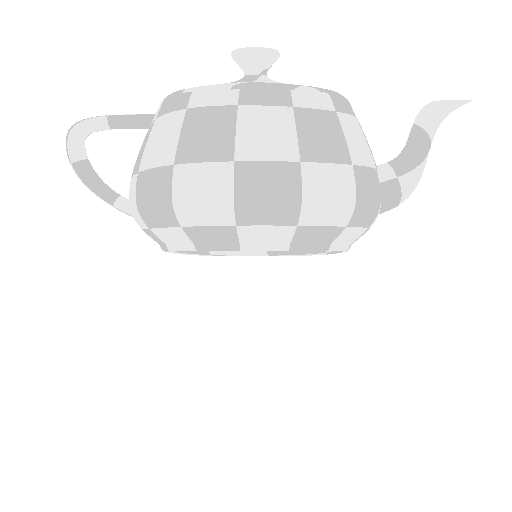

In [3]:
scene = Scene3D('../models/teapot/teapot.obj')

x_r = sampling_lattice(n_r, w_r)
retina_samples = np.stack(np.broadcast_arrays(x_r[:, np.newaxis], x_r[np.newaxis, :], z_r), axis=-1).reshape(-1, 3)

retina_image = scene.rayCast(retina_samples + [0.0, 0.0, -600.0], -retina_samples)
retina_image = np.flip(retina_image.reshape(512, 512, 4), (0, 1))

display(Image.fromarray(retina_image).transpose(Image.ROTATE_90))

scene.release()